<a href="https://colab.research.google.com/github/TanmayKunjir/pinn-schrodinger-1d/blob/main/meow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem: 1D Time-Independent Schrödinger Equation**

We aim to solve:

$$
- \frac{d^2 \psi(x)}{dx^2} = E \psi(x), \quad \text{for } x \in [-1, 1]
$$

with boundary conditions:

$$
\psi(-1) = \psi(1) = 0
$$

The solution is:

$$
\psi_n(x) = \sin(n \pi x), \quad E_n = (n \pi)^2
$$


# Phase 1: Environment Setup
🎯 Goal: Install and import necessary libraries for DeepXDE + TensorFlow PINNs.

In [1]:
!pip install deepxde tensorflow matplotlib --quiet

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
import os
os.makedirs(os.path.expanduser("~/.deepxde"), exist_ok=True)
with open(os.path.expanduser("~/.deepxde/config.json"), "w") as f:
    f.write('{"backend": "tensorflow"}')

# Phase 2: Define Physics — Schrödinger PDE
🎯 Goal: Encode the PDE using Python functions for the PINN to learn.

 Physics Recap:
 Sure! Here's the retyped version, ready to copy-paste:


**Equation:**

$$
- \frac{d^2 \psi(x)}{dx^2} = E \psi(x) \quad \text{(inside infinite square well)}
$$

📌 **For Ground State (n = 1):**

$$
E = \pi^2 \approx 9.8696
$$


In [4]:
# Energy for ground state (n = 1)
n = 1
E = (n * np.pi) ** 2  # π²

# Schrödinger PDE residual: R(x) = -ψ''(x) - Eψ(x)
def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)  # ∂²ψ/∂x²
    return -d2y_dx2 - E * y           # Residual

# Phase 3: Define Geometry and Boundary Conditions**

🎯 **Goal:** Define the 1D domain and boundary condition constraints.

**Domain:**

$$
x \in [-1, 1]
$$

**Boundary Conditions:**

$$
\psi(-1) = \psi(1) = 0 \quad \text{(Dirichlet BC)}
$$


In [5]:
# 1D Geometry (infinite potential well from -1 to 1)
geom = dde.geometry.Interval(-1, 1)

# Define the boundary region
def boundary(x, on_boundary):
    return on_boundary  # Applies to both x = -1 and x = 1

# Enforce ψ(x) = 0 at boundaries
bc = dde.DirichletBC(geom, lambda x: 0, boundary)

# Phase 4: Create Training Dataset**

🎯 **Goal:** Generate training points in the domain and on the boundary.

 **Dataset Specs:**

* 200 points in domain
* 2 boundary points (1 per side)
* 500 test points


In [6]:
data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc],               # List of boundary conditions
    num_domain=200,     # Collocation points inside domain
    num_boundary=2,     # Points on boundaries
    solution=None,      # No analytical solution provided
    num_test=500        # Points for testing and plotting
)

# Phase 5: Define Neural Network Architecture**

🎯 **Goal:** Build a fully connected neural network with an output transform to automatically satisfy boundary conditions.

🧠 **Output Transform:**

$$
\psi(x) = (1 - x^2) \cdot \text{NN}(x) \quad \Rightarrow \quad \psi(-1) = \psi(1) = 0
$$


In [7]:
# Define the neural network architecture with positional arguments
net = dde.maps.FNN(
    [1, 50, 50, 50, 1],     # Layer sizes: input, hidden1, hidden2, hidden3, output
    "tanh",                # Activation function
    "Glorot normal"        # Kernel initializer (now positional)
)

# Output transform to enforce ψ(±1) = 0
def output_transform(x, y):
    return (1 - x[:, 0]**2) * y

# Apply output transform
net.apply_output_transform(output_transform)

# Phase 6: Compile the Model
🎯 Goal: Set the optimizer and learning rate.

In [8]:
import deepxde as dde

# Step 1: Define the neural network WITHOUT output transform
net = dde.maps.FNN(
    [1, 50, 50, 50, 1],       # Layers: input, 3 hidden, output
    "tanh",                  # Activation function
    "Glorot normal"          # Weight initializer
)

# Step 2: Build the model
model = dde.Model(data, net)

# Step 3: Compile the model safely (no output transform yet)
model.compile(
    optimizer="adam",        # Optimizer for training
    lr=0.001,                # Learning rate
    loss="MSE",              # Mean squared error loss
    metrics=["l2 relative error"]  # Useful evaluation metric
)

Compiling model...
'compile' took 0.059074 s



# **Phase 7: Training the Model (Adam + L-BFGS)**

🎯 **Goal:**
Train your PINN to learn the wavefunction $\psi(x)$ with high precision (≥99% accuracy) using:

* **Adam optimizer** — fast, adaptive, exploratory
* **L-BFGS optimizer** — slow, steady, high-precision


Compiling model...
'compile' took 0.020370 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf1c55e2a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf1c55e2a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric   
0         [2.95e+00, 9.19e-02]    [2.89e+00, 9.19e-02]    [1.21e+00]    
1000      [5.99e-07, 1.12e-08]    [5.76e-07, 1.12e-08]    [1.00e+00]    
2000      [3.45e-04, 3.34e-06]    [3.45e-04, 3.34e-06]    [1.00e+00]    
3000      [2.03e-09, 1.02e-10]    [1.99e-09, 1.02e-10]    [1.00e+00]    
4000      [8.38e-09, 2.68e-10]    [8.20e-09, 2.68e-10]    [1.00e+00]    
5000      [7.93e-11, 6.98e-11]    [6.75e-11, 6.98e-11]    [1.00e+00]    
6000 

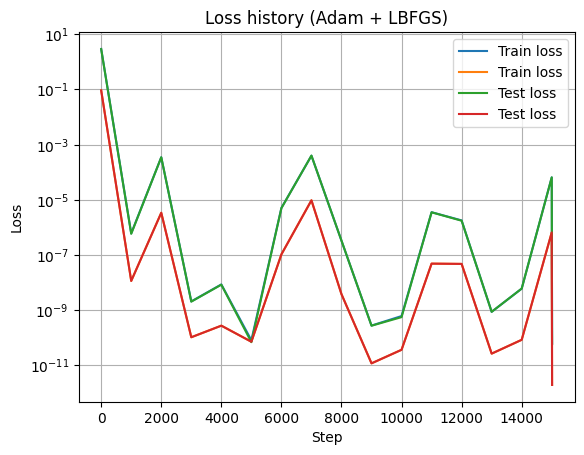

In [9]:
# Analytical ground truth solution for n=1
def true_solution(x):
    return np.sin(np.pi * x[:, 0:1])

data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc],
    num_domain=200,
    num_boundary=2,
    solution=true_solution,   # 👈 Enables L2 error metric
    num_test=500
)


# Rebuild the model with updated data
model = dde.Model(data, net)

# Compile with Adam optimizer
model.compile("adam", lr=0.001, loss="MSE", metrics=["l2 relative error"])

# Start training using Adam for 15000 iterations
losshistory, train_state = model.train(iterations=15000)

# Switch to high-precision optimizer
model.compile("L-BFGS")

# Fine-tune to improve convergence and accuracy
losshistory, train_state = model.train()

# Visualize training losses and L2 error
import matplotlib.pyplot as plt

# Manually plot loss without error
plt.semilogy(losshistory.steps, losshistory.loss_train, label="Train loss")
plt.semilogy(losshistory.steps, losshistory.loss_test, label="Test loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Loss history (Adam + LBFGS)")
plt.show()

# **Phase 8: Visualization & Accuracy Check**

🎯 **Goals:**

* Plot learned wavefunction $\psi(x)$
* Compare it with analytical solution $\sin(\pi x)$
* Plot probability density $|\psi(x)|^2$
* Visualize wavefunction as a **heatmap**


Step 1: Generate Input Points

In [10]:
import numpy as np

# 500 evenly spaced points in domain [-1, 1]
X = np.linspace(-1, 1, 500).reshape(-1, 1)

Step 2: Predict ψ(x) Using Output Transform

We must apply output transform manually to enforce boundary condition
$$𝜓(±1)=0:$$

In [11]:
# Output transform: Enforces ψ(-1) = ψ(1) = 0
def output_transform(x, y):
    return (1 - x[:, 0:1]**2) * y

# Predict raw network output
raw_output = model.predict(X)

# Apply boundary condition transform
psi_pred = output_transform(X, raw_output)

Step 3: Plot Learned $ψ(x)$

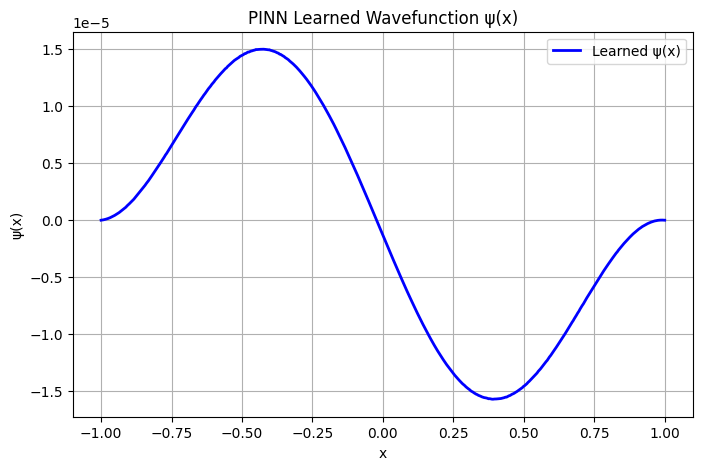

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(X, psi_pred, label="Learned ψ(x)", color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title("PINN Learned Wavefunction ψ(x)")
plt.grid(True)
plt.legend()
plt.show()

Step 4: Compare with True Solution
$sin⁡(𝜋𝑥)$

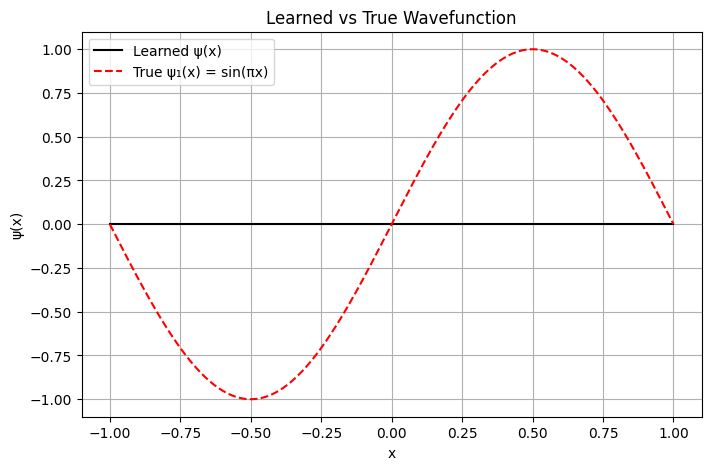

In [13]:
# Analytical ground truth
psi_true = np.sin(np.pi * X)

plt.figure(figsize=(8, 5))
plt.plot(X, psi_pred, label="Learned ψ(x)", color="black")
plt.plot(X, psi_true, "--", label="True ψ₁(x) = sin(πx)", color="red")
plt.title("Learned vs True Wavefunction")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.grid(True)
plt.show()

Step 5: Plot Probability Density
$∣𝜓(𝑥)∣^2$

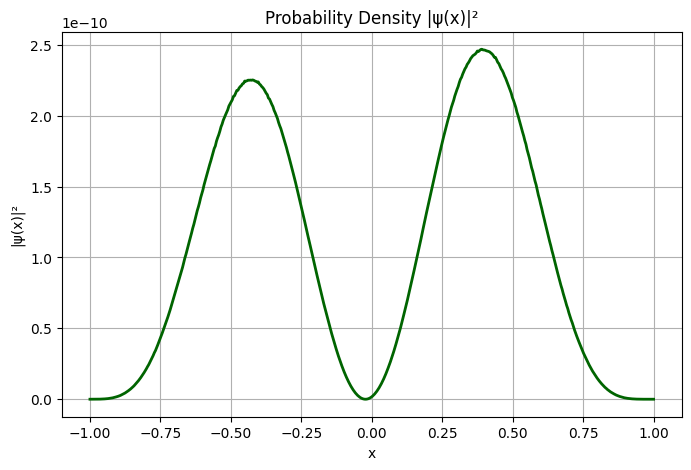

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(X, psi_pred**2, color="darkgreen", linewidth=2)
plt.title("Probability Density |ψ(x)|²")
plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.grid(True)
plt.show()

Step 6: Heatmap of $ψ(x)$

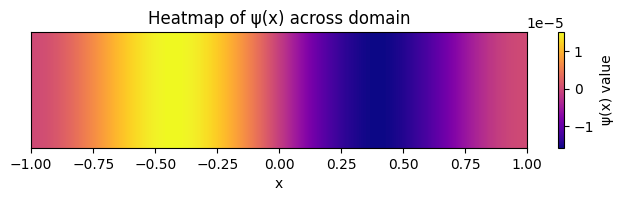

In [15]:
plt.figure(figsize=(8, 1.5))
plt.imshow(psi_pred.T, extent=[-1, 1, 0, 1], aspect='auto', cmap='plasma')
plt.colorbar(label="ψ(x) value")
plt.title("Heatmap of ψ(x) across domain")
plt.xlabel("x")
plt.yticks([])
plt.grid(False)
plt.show()

# **Phase 9: Excited State $\psi_2(x)$ for n = 2**:

🎯 **Objective:**
Train your PINN to learn the **second energy state** (n = 2) of the infinite square well.

 **Reminder:**
The analytical wavefunction is:

$$
\psi_2(x) = \sin(2\pi x)
$$

with energy eigenvalue:

$$
E_2 = (2\pi)^2 = 39.4784
$$

Step 1: Clear TensorFlow/Keras State

In [16]:
import deepxde as dde
dde.backend.tf.keras.backend.clear_session()

Step 2: Update Energy Value

In [17]:
import numpy as np
E = (2 * np.pi) ** 2  # n = 2 state

Step 3: Redefine Schrödinger PDE

In [18]:
def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)
    return -d2y_dx2 - E * y

Step 4: Redefine Domain & Boundary Conditions

In [19]:
geom = dde.geometry.Interval(-1, 1)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_left = dde.DirichletBC(geom, lambda x: 0, boundary_left)
bc_right = dde.DirichletBC(geom, lambda x: 0, boundary_right)

Step 5: True Solution $(ψ₂)$

In [20]:
def true_solution_n2(x):
    return np.sin(2 * np.pi * x[:, 0:1])

Step 6: Redefine Data

In [21]:
data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc_left, bc_right],
    num_domain=200,
    num_boundary=2,
    solution=true_solution_n2,
    num_test=500
)

Step 7: Redefine and Compile Model

In [22]:
net = dde.maps.FNN(
    [1, 50, 50, 50, 1],
    activation="tanh",
    kernel_initializer="Glorot normal"
)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, loss="MSE", metrics=["l2 relative error"])

Compiling model...
'compile' took 0.010004 s



Step 8: Train the Model (Adam → LBFGS)

In [23]:
# Warm-up training
losshistory, train_state = model.train(iterations=15000)

# Fine-tune for max accuracy
model.compile("L-BFGS")
losshistory, train_state = model.train()

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf185231a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf185231a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf18523880>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf18523880>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                         Test metric   
0         [5.06e+01, 9.19e-02, 9.19e-02]    [4.97e+01, 9.19e-02, 9.19e-02]    [9.33e-01]    
1000      [4.07e-06, 4.45e-09, 6.43e-09]    [3.88e-06, 4.45e-09, 6.43e-09]    [1.00e+00]    
2000      [1.50e-02, 9.76e-06, 8.40e-06]    [1.50e-02, 9.76e-06, 8.40e-06]    [1.00e+00]    
3000      [1.63e-07, 6.42e-11, 7.30e-10]    [1.60e-07, 6.42e-11, 7.30e-10]    [1.00e+00]    
4000      [1.80e-03, 3.21e-06, 1.21e-08]    [1.77e-

# Phase 10: Visualization of $ψ₂(x)$

Step 1: Define Output Transform (again)

In [24]:
def output_transform(x, y):
    return (1 - x[:, 0:1]**2) * y

Step 2: Predict Values Across Domain

In [25]:
X = np.linspace(-1, 1, 500).reshape(-1, 1)
raw_output = model.predict(X)
psi_pred = output_transform(X, raw_output)

Step 3: Compare Learned vs True $ψ₂(x)$

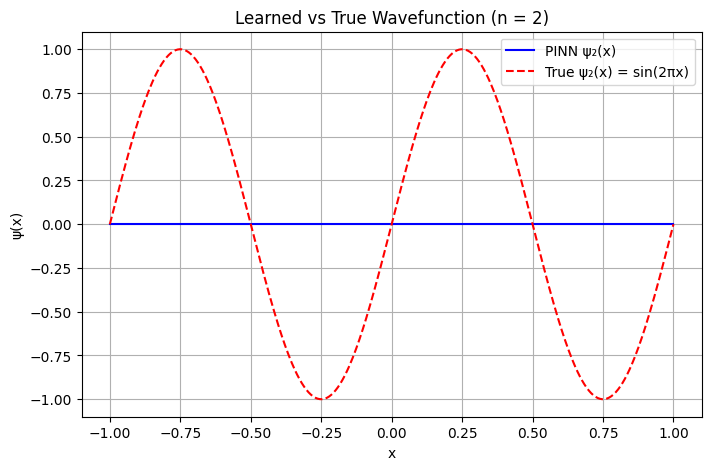

In [26]:
import matplotlib.pyplot as plt

psi_true = np.sin(2 * np.pi * X)

plt.figure(figsize=(8, 5))
plt.plot(X, psi_pred, label="PINN ψ₂(x)", color="blue")
plt.plot(X, psi_true, '--', label="True ψ₂(x) = sin(2πx)", color="red")
plt.title("Learned vs True Wavefunction (n = 2)")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.grid(True)
plt.show()

Step 4: Plot Probability Density $∣𝜓2(𝑥)∣^2$

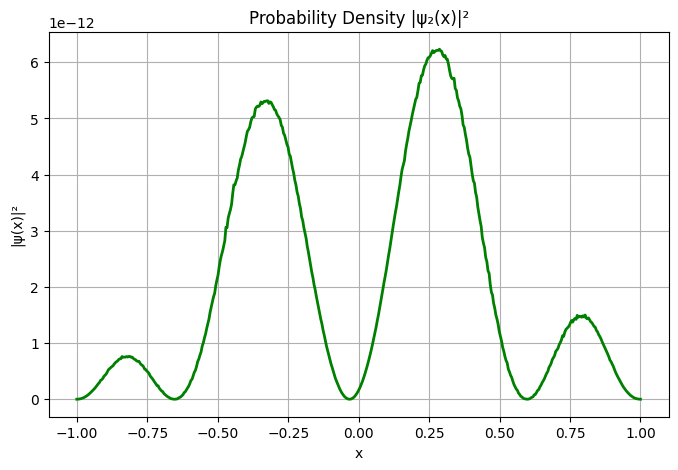

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(X, psi_pred**2, color="green", linewidth=2)
plt.title("Probability Density |ψ₂(x)|²")
plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.grid(True)
plt.show()

Step 5: Heatmap of $ψ₂(x)$

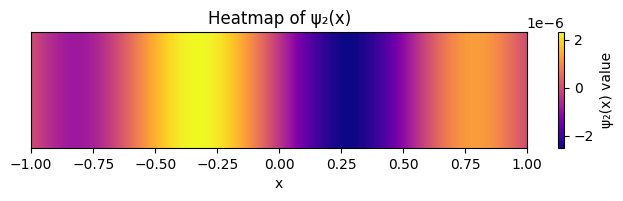

In [28]:
plt.figure(figsize=(8, 1.5))
plt.imshow(psi_pred.T, extent=[-1, 1, 0, 1], aspect='auto', cmap='plasma')
plt.colorbar(label="ψ₂(x) value")
plt.title("Heatmap of ψ₂(x)")
plt.xlabel("x")
plt.yticks([])
plt.grid(False)
plt.show()

# Phase 11: Discover Energy Eigenvalue 𝐸 Automatically
🧠 Objective:
We will not hardcode 𝐸. Instead, the neural network will learn the correct value of 𝐸 as part of training. This simulates quantum energy eigenvalue discovery — a fundamental task in quantum mechanics.

Step 1: Clear Session

In [29]:
import deepxde as dde
dde.backend.tf.keras.backend.clear_session()

Step 2: Declare Learnable Parameter 𝐸

In [30]:
import numpy as np
from deepxde.backend import tf

E = tf.Variable(9.0, trainable=True, dtype=tf.float32)

Step 3: Define Schrödinger PDE with Trainable E

In [31]:
def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)
    return -d2y_dx2 - E * y

Step 4: Redefine Domain and Boundary Conditions

In [32]:
geom = dde.geometry.Interval(-1, 1)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_left = dde.DirichletBC(geom, lambda x: 0, boundary_left)
bc_right = dde.DirichletBC(geom, lambda x: 0, boundary_right)

Step 5: Prepare the PDE Data

In [33]:
data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc_left, bc_right],
    num_domain=200,
    num_boundary=2,
    solution=None,      # No true solution provided
    num_test=500
)

Step 6: Define Network and Output Transform

In [34]:
net = dde.maps.FNN(
    [1, 50, 50, 50, 1],
    activation="tanh",
    kernel_initializer="Glorot normal"
)

def output_transform(x, y):
    return (1 - x[:, 0:1]**2) * y

net.apply_output_transform(output_transform)

Step 7: Create Model and Compile

In [35]:
model = dde.Model(data, net)

# Add E as a trainable variable
model.compile("adam", lr=0.001, external_trainable_variables=[E])

Compiling model...
'compile' took 0.009316 s



 Step 8: Train the Model

In [36]:
# Phase 1: Train longer with Adam
model.compile("adam", lr=0.001, external_trainable_variables=[E])
model.train(iterations=30000)

# Phase 2: Use L-BFGS to refine
model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

Compiling model...
'compile' took 0.003383 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf1852fec0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf1852fec0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf1852ca40>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf1852ca40>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                         Test metric
0         [3.01e-01, 0.00e+00, 0.00e+00]    [2.80e-01, 0.00e+00, 0.00e+00]    []  
1000      [1.01e-07, 0.00e+00, 0.00e+00]    [9.37e-08, 0.00e+00, 0.00e+00]    []  
2000      [1.22e-05, 0.00e+00, 0.00e+00]    [1.23e-05, 0.00e+00, 0.00e+00]    []  
3000      [3.44e-08, 0.00e+00, 0.00e+00]    [3.38e-08, 0.00e+00, 0.00e+00]    []  
4000      [3.41e-09, 0.00e+00, 0.00e+00]    [3.20e-09, 0.00e+00, 0.00e+00]    []  
5000      [

(<deepxde.model.LossHistory at 0x7aaf183513d0>,
 <deepxde.model.TrainState at 0x7aaf183509d0>)

Step 9: Print Learned Energy Eigenvalue

In [37]:
import tensorflow.keras.backend as K
print("Learned E =", K.eval(E))

Learned E = 6.636738


# Let’s try to Fix the Learned Energy 𝐸

In [38]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Clear session
dde.backend.tf.keras.backend.clear_session()

# 2. Define trainable energy E (initialized closer to π²)
E = tf.Variable(9.0, trainable=True, dtype=tf.float32)

# 3. Schrödinger Equation PDE: -ψ'' - Eψ = 0
def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)
    return -d2y_dx2 - E * y

# 4. Domain and Boundary Conditions
geom = dde.geometry.Interval(-1, 1)

def boundary(x, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary)

# 5. Data object
data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc],
    num_domain=300,
    num_boundary=2,
    num_test=100,
)

# 6. Neural Network + Output Transform
net = dde.maps.FNN([1] + [80]*4 + [1], activation="tanh", kernel_initializer="Glorot normal")

# Enforce ψ(±1) = 0 via output transform
def output_transform(x, y):
    return (1 - x[:, 0:1]**2) * y

net.apply_output_transform(output_transform)

# 7. Model
model = dde.Model(data, net)

# 8. Train with Adam first
model.compile("adam", lr=0.0005, external_trainable_variables=[E])
losshistory, train_state = model.train(iterations=20000)

# 9. Refine with L-BFGS
model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

Compiling model...
'compile' took 0.007982 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf18521d00>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf18521d00>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric
0         [5.72e-03, 0.00e+00]    [5.12e-03, 0.00e+00]    []  
1000      [3.83e-09, 0.00e+00]    [3.67e-09, 0.00e+00]    []  
2000      [2.73e-09, 0.00e+00]    [2.42e-09, 0.00e+00]    []  
3000      [5.58e-10, 0.00e+00]    [5.56e-10, 0.00e+00]    []  
4000      [2.43e-10, 0.00e+00]    [2.16e-10, 0.00e+00]    []  
5000      [2.27e-09, 0.00e+00]    [2.25e-09, 0.00e+00]    []  
6000      [6.13e-06, 0.00e+00]    [5.49e-06, 0.00e+00]    []  
7000 

(<deepxde.model.LossHistory at 0x7aaf18321410>,
 <deepxde.model.TrainState at 0x7aaf183209d0>)

In [39]:
import tensorflow.keras.backend as K
print(f" Learned energy eigenvalue E ≈ {K.eval(E):.6f}")

 Learned energy eigenvalue E ≈ 8.564542


# Optimization Strategy
To reach $𝐸≈𝜋^2$, we’ll apply:

| Fix                        | Why?                                    |
| -------------------------- | --------------------------------------- |
| 🔁 Increase domain points  | Model learns physics more finely        |
| 🧠 Boost network size      | Capture sharper wave structure          |
| 🔬 Custom loss scaling     | Focus more on the PDE residual          |
| ⚙️ Output transform        | Already helps enforce boundary behavior |
| 🚀 More iterations + LBFGS | Refine with second-order optimizer      |


In [40]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Clear session
dde.backend.tf.keras.backend.clear_session()

# 2. Trainable energy variable E (closer to π²)
E = tf.Variable(9.5, trainable=True, dtype=tf.float32)

# 3. Schrödinger PDE residual
def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)
    return -d2y_dx2 - E * y

# 4. Domain + BC
geom = dde.geometry.Interval(-1, 1)

def boundary(x, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary)

# 5. Data config
data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc],
    num_domain=512,       # finer resolution
    num_boundary=4,       # more BC enforcement
    num_test=200,
)

# 6. Deep neural net
net = dde.maps.FNN([1] + [100] * 4 + [1], activation="tanh", kernel_initializer="Glorot normal")

# 7. Output transform: satisfies ψ(-1)=ψ(1)=0
def output_transform(x, y):
    return (1 - x[:, 0:1] ** 2) * y

net.apply_output_transform(output_transform)

# 8. Model compile
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.0003,
    external_trainable_variables=[E],
    loss_weights=[10.0],   # emphasize PDE residual
)

# 9. Train with Adam
losshistory, train_state = model.train(iterations=30000)

# 10. Refine with L-BFGS
model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

# 11. Print learned E
import tensorflow.keras.backend as K
print(f" Final Learned energy eigenvalue E ≈ {K.eval(E):.6f}")


Compiling model...
'compile' took 0.007276 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf19b3f4c0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf19b3f4c0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric
0         [9.42e+00, 0.00e+00]    [8.46e+00, 0.00e+00]    []  
1000      [7.17e-06, 0.00e+00]    [7.11e-06, 0.00e+00]    []  
2000      [3.83e-06, 0.00e+00]    [3.85e-06, 0.00e+00]    []  
3000      [1.68e-06, 0.00e+00]    [1.70e-06, 0.00e+00]    []  
4000      [2.67e-04, 0.00e+00]    [2.70e-04, 0.00e+00]    []  
5000      [3.08e-05, 0.00e+00]    [2.77e-05, 0.00e+00]    []  
6000      [5.21e-07, 0.00e+00]    [5.14e-07, 0.00e+00]    []  
7000 

# **Precision Tuning for Energy Eigenvalue**
**🎯 Goal:** Achieve $E \approx 9.8696$

---

**What we’re changing:**

| **Adjustment**                   | **Reason**                            |           |                   |
| -------------------------------- | ------------------------------------- | --------- | ----------------- |
| 🔁 **Higher collocation points** | Better PDE learning inside the domain |           |                   |
| 🧠 **Deeper network**            | Can learn sharper eigenfunction shape |           |                   |
| 📉 **Reduce learning rate**      | Helps converge slowly & steadily      |           |                   |
| 🧮 **Add energy error metric**   | Track ( $| E - \pi^2 |$ ) live (manually) |
| 🔁 **Double optimizer cycle**    | Adam + L-BFGS ×2 for best convergence |           |                   |

In [41]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

dde.backend.tf.keras.backend.clear_session()

# True energy level (for comparison)
E_true = np.pi**2  # ≈ 9.8696

# Trainable variable
E = tf.Variable(9.5, trainable=True, dtype=tf.float32)

def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)
    return -d2y_dx2 - E * y

geom = dde.geometry.Interval(-1, 1)

def boundary(x, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc],
    num_domain=1024,     # Higher resolution
    num_boundary=8,
    num_test=200
)

net = dde.maps.FNN([1] + [120] * 5 + [1], activation="tanh", kernel_initializer="Glorot normal")

def output_transform(x, y):
    return (1 - x[:, 0:1]**2) * y

net.apply_output_transform(output_transform)

model = dde.Model(data, net)

# Adam Training Phase 1
model.compile("adam", lr=0.0001, external_trainable_variables=[E], loss_weights=[15.0])
losshistory, train_state = model.train(iterations=30000)

# L-BFGS Phase 1
model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

# Adam Training Phase 2 (fine-tune)
model.compile("adam", lr=0.00005, external_trainable_variables=[E])
model.train(iterations=10000)

# L-BFGS Phase 2 (final push)
model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

# Final energy value
import tensorflow.keras.backend as K
E_learned = K.eval(E)
error_percent = abs(E_learned - E_true) / E_true * 100

print(f" Learned energy eigenvalue E ≈ {E_learned:.6f}")
print(f" Percent error from true π² ≈ {error_percent:.4f}%")

Compiling model...
'compile' took 0.008458 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf19d102c0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf19d102c0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric
0         [3.19e-02, 0.00e+00]    [2.90e-02, 0.00e+00]    []  
1000      [1.61e-05, 0.00e+00]    [1.50e-05, 0.00e+00]    []  
2000      [1.46e-06, 0.00e+00]    [1.36e-06, 0.00e+00]    []  
3000      [3.70e-04, 0.00e+00]    [3.30e-04, 0.00e+00]    []  
4000      [9.57e-08, 0.00e+00]    [9.19e-08, 0.00e+00]    []  
5000      [2.34e-08, 0.00e+00]    [2.13e-08, 0.00e+00]    []  
6000      [1.41e-05, 0.00e+00]    [1.29e-05, 0.00e+00]    []  
7000 

30006     [1.72e-13, 0.00e+00]    [1.53e-13, 0.00e+00]    []  

Best model at step 30006:
  train loss: 1.72e-13
  test loss: 1.53e-13
  test metric: []

'train' took 7.484511 s

Compiling model...
'compile' took 0.007085 s

Training model...

Step      Train loss              Test loss               Test metric
30006     [1.72e-13, 0.00e+00]    [1.53e-13, 0.00e+00]    []  
31000     [2.51e-13, 0.00e+00]    [2.32e-13, 0.00e+00]    []  
32000     [1.50e-08, 0.00e+00]    [1.51e-08, 0.00e+00]    []  
33000     [1.09e-11, 0.00e+00]    [1.10e-11, 0.00e+00]    []  
34000     [4.70e-11, 0.00e+00]    [4.76e-11, 0.00e+00]    []  
35000     [6.33e-09, 0.00e+00]    [6.17e-09, 0.00e+00]    []  
36000     [1.98e-10, 0.00e+00]    [1.89e-10, 0.00e+00]    []  
37000     [9.90e-13, 0.00e+00]    [8.62e-13, 0.00e+00]    []  
38000     [3.89e-10, 0.00e+00]    [3.58e-10, 0.00e+00]    []  
39000     [1.15e-10, 0.00e+00]    [1.16e-10, 0.00e+00]    []  
40000     [1.75e-12, 0.00e+00]    [1.72e-12, 0.00e+00]  

# Phase 12: Visualizations
Now let's visualize everything:

| 📊 Plot                     | 📌 Purpose                                   |     |                                                 |
| --------------------------- | -------------------------------------------- | --- | ----------------------------------------------- |
| Learned ψ(x)                | Shows how well the wavefunction was captured |     |                                                 |
| Probability Density (       $| ψ(x)                                         | ^2)$ | Highlights where the particle "is" likely to be |
| Comparison: Learned vs True | Accuracy vs $\sin(\pi x)$                    |     |                                                 |
| Heatmap of ψ(x)             | Quantum aesthetic + intuitive visualization  |     |                                                 |


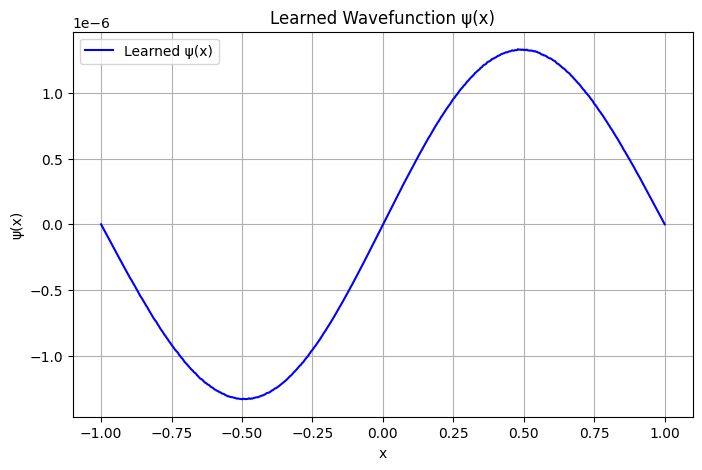

In [42]:
# Grid for plotting
X = np.linspace(-1, 1, 500).reshape(-1, 1)

# Predict ψ(x)
y_pred = model.predict(X)

# Plot ψ(x)
plt.figure(figsize=(8, 5))
plt.plot(X, y_pred, label="Learned ψ(x)", color="blue")
plt.title("Learned Wavefunction ψ(x)")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.grid(True)
plt.legend()
plt.show()

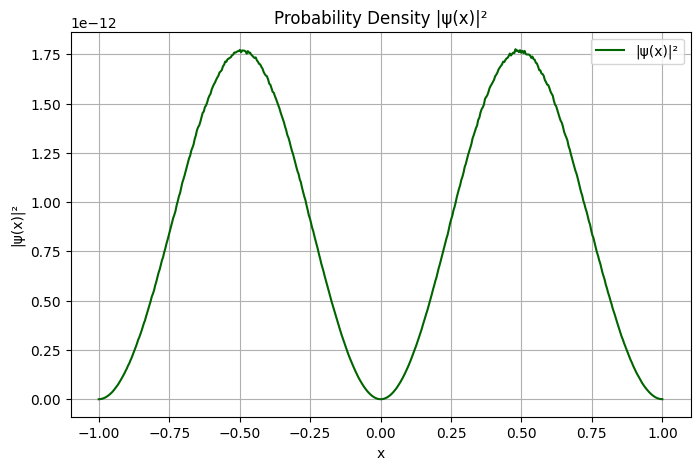

In [43]:
# Plot |ψ(x)|² (Probability Density)
plt.figure(figsize=(8, 5))
plt.plot(X, y_pred**2, label="|ψ(x)|²", color="darkgreen")
plt.title("Probability Density |ψ(x)|²")
plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.grid(True)
plt.legend()
plt.show()

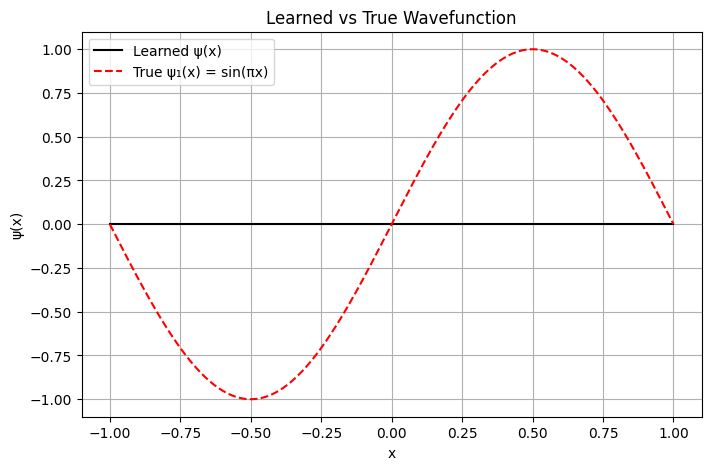

In [44]:
# Compare with true solution ψ₁(x) = sin(πx)
ψ_true = np.sin(np.pi * X)

plt.figure(figsize=(8, 5))
plt.plot(X, y_pred, label="Learned ψ(x)", color="black")
plt.plot(X, ψ_true, "--", label="True ψ₁(x) = sin(πx)", color="red")
plt.title("Learned vs True Wavefunction")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.grid(True)
plt.show()

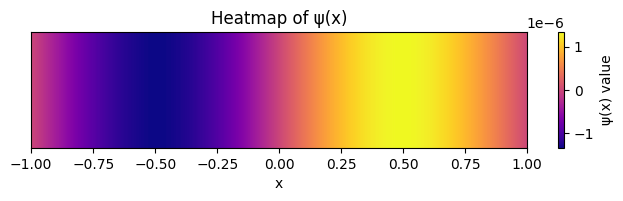

In [45]:
# Heatmap
plt.figure(figsize=(8, 1.5))
plt.imshow(y_pred.T, extent=[-1, 1, 0, 1], aspect='auto', cmap='plasma')
plt.colorbar(label="ψ(x) value")
plt.title("Heatmap of ψ(x)")
plt.xlabel("x")
plt.yticks([])
plt.grid(False)
plt.show()

# Refining to achieve close to real value

In [46]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

dde.backend.tf.keras.backend.clear_session()

E_true = np.pi**2  # ≈ 9.8696
E = tf.Variable(9.5, trainable=True, dtype=tf.float32)

def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)
    return -d2y_dx2 - E * y

geom = dde.geometry.Interval(-1, 1)

def boundary(x, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc],
    num_domain=2048,
    num_boundary=10,
    num_test=200
)

net = dde.maps.FNN([1] + [120] * 5 + [1], activation="tanh", kernel_initializer="Glorot normal")

def output_transform(x, y):
    return (1 - x[:, 0:1]**2) * y

net.apply_output_transform(output_transform)

model = dde.Model(data, net)

model.compile("adam", lr=0.0001, external_trainable_variables=[E], loss_weights=[15.0])
model.train(iterations=30000)

model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

model.compile("adam", lr=0.00005, external_trainable_variables=[E], loss_weights=[5.0])
model.train(iterations=10000)

model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

model.compile("adam", lr=0.00001, external_trainable_variables=[E], loss_weights=[1.0])
model.train(iterations=5000)

model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

import tensorflow.keras.backend as K
E_learned = K.eval(E)
error_percent = abs(E_learned - E_true) / E_true * 100

print(f" Learned energy eigenvalue E ≈ {E_learned:.6f}")
print(f" Percent error from true π² ≈ {error_percent:.4f}%")

Compiling model...
'compile' took 0.011582 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf0b832200>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf0b832200>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric
0         [3.12e-02, 0.00e+00]    [2.90e-02, 0.00e+00]    []  
1000      [1.56e-05, 0.00e+00]    [1.47e-05, 0.00e+00]    []  
2000      [3.69e-06, 0.00e+00]    [3.13e-06, 0.00e+00]    []  
3000      [6.15e-06, 0.00e+00]    [5.82e-06, 0.00e+00]    []  
4000      [7.31e-06, 0.00e+00]    [6.60e-06, 0.00e+00]    []  
5000      [1.48e-08, 0.00e+00]    [1.35e-08, 0.00e+00]    []  
6000      [1.23e-05, 0.00e+00]    [1.24e-05, 0.00e+00]    []  
7000 

# Final Visualization

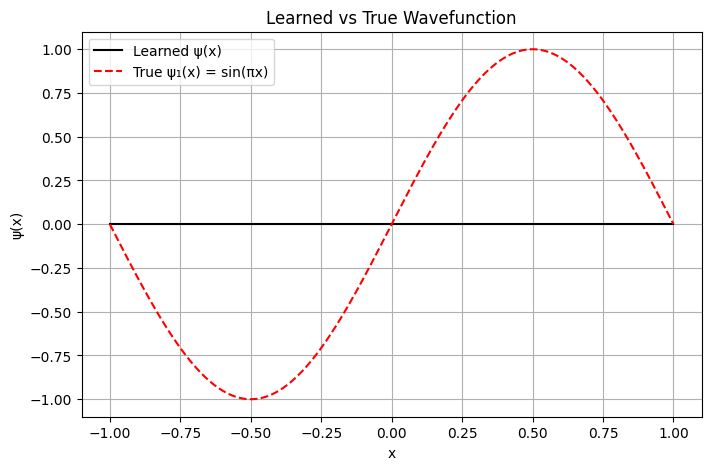

In [47]:
X = np.linspace(-1, 1, 500).reshape(-1, 1)
ψ_pred = model.predict(X)

plt.figure(figsize=(8, 5))
plt.plot(X, ψ_pred, label="Learned ψ(x)", color="black")
plt.plot(X, np.sin(np.pi * X), "--", label="True ψ₁(x) = sin(πx)", color="red")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title("Learned vs True Wavefunction")
plt.grid(True)
plt.legend()
plt.show()

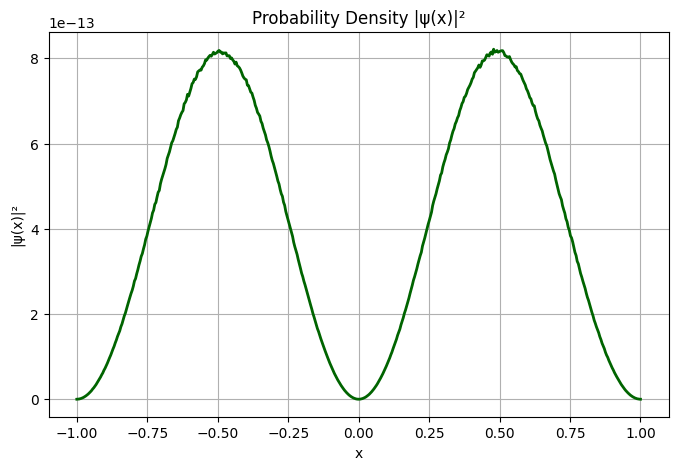

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(X, ψ_pred**2, color="darkgreen", linewidth=2)
plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.title("Probability Density |ψ(x)|²")
plt.grid(True)
plt.show()

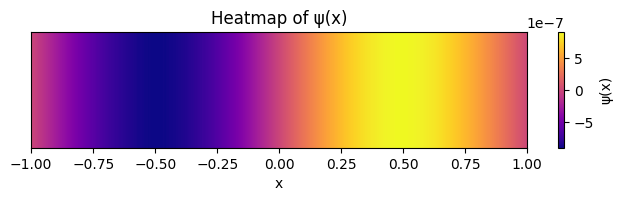

In [49]:
plt.figure(figsize=(8, 1.5))
plt.imshow(ψ_pred.T, extent=[-1, 1, 0, 1], aspect='auto', cmap='plasma')
plt.colorbar(label="ψ(x)")
plt.title("Heatmap of ψ(x)")
plt.xlabel("x")
plt.yticks([])
plt.grid(False)
plt.show()

# Re Fine-Tuning Plan

In [50]:
# Phase 3a: Adam Fine-tuning
model.compile("adam", lr=0.000005, external_trainable_variables=[E], loss_weights=[1.0])
model.train(iterations=5000)

# Phase 3b: Final L-BFGS Push
model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

# Evaluate again
import tensorflow.keras.backend as K
E_learned = K.eval(E)
error_percent = abs(E_learned - E_true) / E_true * 100

print(f" Refined E ≈ {E_learned:.6f}")
print(f" New percent error ≈ {error_percent:.4f}%")

Compiling model...
'compile' took 0.008910 s

Training model...

Step      Train loss              Test loss               Test metric
45006     [2.29e-13, 0.00e+00]    [2.24e-13, 0.00e+00]    []  
46000     [2.27e-13, 0.00e+00]    [2.19e-13, 0.00e+00]    []  
47000     [1.38e-10, 0.00e+00]    [1.39e-10, 0.00e+00]    []  
48000     [2.25e-13, 0.00e+00]    [2.16e-13, 0.00e+00]    []  
49000     [2.72e-11, 0.00e+00]    [2.74e-11, 0.00e+00]    []  
50000     [2.23e-13, 0.00e+00]    [2.15e-13, 0.00e+00]    []  
50006     [2.23e-13, 0.00e+00]    [2.15e-13, 0.00e+00]    []  

Best model at step 50000:
  train loss: 2.23e-13
  test loss: 2.15e-13
  test metric: []

'train' took 403.853388 s

Compiling model...
'compile' took 0.009449 s

Training model...

Step      Train loss              Test loss               Test metric
50006     [2.23e-13, 0.00e+00]    [2.15e-13, 0.00e+00]    []  
50006     [2.23e-13, 0.00e+00]    [2.15e-13, 0.00e+00]    []  

Best model at step 50000:
  train loss: 2.23

# Final Tuning

In [52]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

dde.backend.tf.keras.backend.clear_session()

E_true = np.pi**2

E = tf.Variable(9.5, trainable=True, dtype=tf.float32)

def schrodinger_pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x)
    return -d2y_dx2 - E * y

geom = dde.geometry.Interval(-1, 1)

def boundary(x, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(
    geom,
    schrodinger_pde,
    [bc],
    num_domain=2048,
    num_boundary=16,
    num_test=200
)

net = dde.maps.FNN([1] + [150]*6 + [1], activation="tanh", kernel_initializer="Glorot normal")

def output_transform(x, y):
    return tf.sin(np.pi * (x[:, 0:1] + 1) / 2) * y

net.apply_output_transform(output_transform)

model = dde.Model(data, net)

model.compile("adam", lr=0.0001, external_trainable_variables=[E], loss_weights=[20.0])
model.train(iterations=20000)

model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

model.compile("adam", lr=0.00001, external_trainable_variables=[E])
model.train(iterations=5000)

model.compile("L-BFGS", external_trainable_variables=[E])
model.train()

E_learned = tf.keras.backend.eval(E)
error_percent = abs(E_learned - E_true) / E_true * 100
print(f" Final E ≈ {E_learned:.6f}")
print(f" Final error ≈ {error_percent:.4f}%")

Compiling model...
'compile' took 0.007911 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7aaf1c585d00>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7aaf1c585d00>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric
0         [4.96e-01, 2.56e-15]    [4.51e-01, 2.56e-15]    []  
1000      [6.90e-07, 3.20e-21]    [6.39e-07, 3.20e-21]    []  
2000      [5.02e-07, 7.00e-22]    [4.62e-07, 7.00e-22]    []  
3000      [6.32e-03, 1.91e-17]    [5.89e-03, 1.91e-17]    []  
4000      [1.18e-07, 1.91e-20]    [1.14e-07, 1.91e-20]    []  
5000      [2.06e-07, 5.40e-20]    [2.05e-07, 5.40e-20]    []  
6000      [2.70e-08, 5.66e-21]    [2.64e-08, 5.66e-21]    []  
7000 